# FrozenLake Q-Network Learning

In [13]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Load the environment

In [14]:
# env = gym.make('FrozenLake-v0')
env = gym.make('FrozenLake8x8-v0')

[2017-07-08 14:25:02,150] Making new env: FrozenLake8x8-v0


In [15]:
print(env.observation_space.n)

64


In [16]:
print(env.action_space.n)

4


## The Q-Network Approach

### Implementing the network itself

In [17]:
tf.reset_default_graph()

In [18]:
# the state encoded in a one-hot vector (1x16)
input_state = tf.placeholder(shape=[None, env.observation_space.n], dtype=tf.float32, name="input_state")
# weights
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))
# a vector of 4 Q-values, one for each action.
Q = tf.matmul(input_state, W)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
target = tf.placeholder(shape=[1,env.action_space.n], dtype=tf.float32, name="target")
loss = tf.reduce_sum(tf.square(target - Q))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

### Training the network

In [19]:
def get_input(state):
    n_space = env.observation_space.n
    return np.eye(n_space)[state].reshape(1,n_space)

In [20]:
# Set learning parameters
gamma = .99
epsilon = 0.1
num_episodes = 10000

#create lists to contain total rewards and steps per episode
report_episodes = 500
step_report = []
win_report = []
step_list = []
reward_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_episodes):
        #Reset environment and get first new observation
        state = env.reset()
        reward_per_episode = 0
        done = False
        step_count = 0
        #The Q-Network
        while True:
            step_count += 1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            Q_current = sess.run(Q, feed_dict={input_state: get_input(state)})
            # e-greedy
            if np.random.rand(1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_current[0])
            #Get new state and reward from environment
            next_state, reward, done, _ = env.step(action)
            #Obtain the Q' values by feeding the new state through our network and set our target value for chosen action.
            targetQ = Q_current
            Q_next = sess.run(Q, feed_dict={input_state: get_input(next_state)})
            targetQ[0, action] = reward + gamma * np.max(Q_next)
            #Train our network using target and predicted Q values
            sess.run(optimizer, feed_dict={input_state:get_input(state), target:targetQ})
            reward_per_episode += reward
            state = next_state
            if done == True:
                #Reduce chance of random action as we train the model.
                epsilon = 1./((i/50) + 10)
                break

        step_list.append(step_count)
        reward_list.append(reward_per_episode)

        if (i+1)%report_episodes == 0:
            avg_step = np.mean(step_list)
            win_ratio = np.sum(reward_list) / report_episodes
            step_report.append(avg_step)
            win_report.append(win_ratio)
            step_list = []
            reward_list = []
            print("{}/{} Average Step: {} Winning Ratio: {} %".format(i+1, num_episodes, avg_step, win_ratio))
        
    final_Q = sess.run(Q, feed_dict={input_state: np.eye(env.observation_space.n)})

500/10000 Average Step: 25.386 Winning Ratio: 0.014 %
1000/10000 Average Step: 18.104 Winning Ratio: 0.002 %
1500/10000 Average Step: 29.112 Winning Ratio: 0.032 %
2000/10000 Average Step: 51.18 Winning Ratio: 0.128 %
2500/10000 Average Step: 69.246 Winning Ratio: 0.346 %
3000/10000 Average Step: 75.194 Winning Ratio: 0.556 %
3500/10000 Average Step: 82.116 Winning Ratio: 0.634 %
4000/10000 Average Step: 85.518 Winning Ratio: 0.646 %
4500/10000 Average Step: 98.34 Winning Ratio: 0.73 %
5000/10000 Average Step: 90.522 Winning Ratio: 0.76 %
5500/10000 Average Step: 89.054 Winning Ratio: 0.74 %
6000/10000 Average Step: 86.07 Winning Ratio: 0.692 %
6500/10000 Average Step: 94.28 Winning Ratio: 0.77 %
7000/10000 Average Step: 90.878 Winning Ratio: 0.742 %
7500/10000 Average Step: 95.836 Winning Ratio: 0.72 %
8000/10000 Average Step: 89.624 Winning Ratio: 0.742 %
8500/10000 Average Step: 99.45 Winning Ratio: 0.718 %
9000/10000 Average Step: 98.89 Winning Ratio: 0.766 %
9500/10000 Average Ste

In [21]:
print("Final Q-Table")
print(final_Q)

Final Q-Table
[[  2.77661145e-01   2.92900383e-01   2.75857359e-01   3.58607829e-01]
 [  2.98503429e-01   2.97342360e-01   3.01543564e-01   3.67375225e-01]
 [  3.14995974e-01   3.27584714e-01   3.16110611e-01   3.91406089e-01]
 [  3.41370851e-01   3.51604283e-01   4.24366325e-01   3.46357942e-01]
 [  3.70614767e-01   3.71013641e-01   3.72811854e-01   4.52241987e-01]
 [  3.96944702e-01   3.96727920e-01   4.85556513e-01   3.97776186e-01]
 [  4.19252425e-01   4.17356282e-01   4.99697030e-01   4.19955373e-01]
 [  4.23173308e-01   4.39260751e-01   5.11259556e-01   4.39976215e-01]
 [  2.96748817e-01   1.99707776e-01   1.80317119e-01   1.43942550e-01]
 [  2.23099098e-01   2.51512855e-01   2.64432430e-01   3.17522615e-01]
 [  2.64992148e-01   2.68986434e-01   2.67664671e-01   3.71118009e-01]
 [  2.52012908e-01   3.08125526e-01   2.64806807e-01   4.09491539e-01]
 [  3.47322226e-01   3.41540068e-01   3.49298149e-01   4.36475396e-01]
 [  3.70561719e-01   3.68617535e-01   3.47264856e-01   4.727844

In [22]:
print("0:LEFT, 1:DOWN, 2:RIGHT, 3:UP")
print(np.argmax(final_Q, axis=1).reshape(-1, env.action_space.n))

0:LEFT, 1:DOWN, 2:RIGHT, 3:UP
[[3 3 3 2]
 [3 2 2 2]
 [0 3 3 3]
 [3 3 2 2]
 [1 3 3 1]
 [0 1 2 1]
 [2 3 0 3]
 [3 0 2 2]
 [3 2 3 3]
 [3 2 3 2]
 [1 2 3 1]
 [0 0 0 2]
 [2 3 3 3]
 [0 2 0 2]
 [1 0 1 3]
 [3 1 3 0]]


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

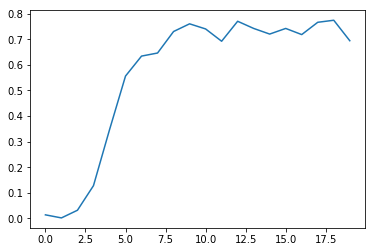

In [23]:
plt.plot(win_report)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

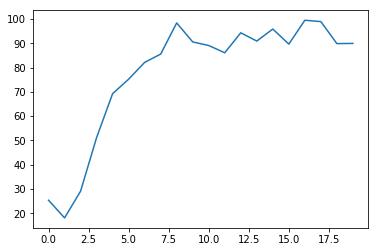

In [24]:
plt.plot(step_report)